In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml
import matplotlib.patches as mpatches

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [2]:
llat = [49.316369,49.543061]
llon = [-124.244478,-123.986083]
def transect_deploy(llat,llon,N):
    '''use decimal coordinates, only works without coordinate sign changes'''
    dxlat = abs(llat[0]-llat[1])/(N-1)
    dxlon = abs(llon[0]-llon[1])/(N-1)
    clat = []
    clon = []
    for i in range(N):
        clat.append(llat[0]+i*dxlat)
        clon.append(llon[0]+i*dxlon)
    return clat, clon

In [3]:
conc=xr.open_dataarray('/home/jvalenti/MOAD/results/All_kernel_Summer2_prob2020.nc')
conc1=xr.open_dataarray('/home/jvalenti/MOAD/results/Nobiof_Summer2_prob2020.nc')
conc2=xr.open_dataarray('/home/jvalenti/MOAD/results/Turb_off_Summer2_prob2020.nc')
conc3=xr.open_dataarray('/home/jvalenti/MOAD/results/No_float_Summer2_prob2020.nc')
conc4=xr.open_dataarray('/home/jvalenti/MOAD/results/No_float-turb_Summer2_prob2020.nc')

local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [8]:
paths = path(0)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'], decode_times=False)
lat0 = coords.gphif[0,:,:]
lon0 = coords.glamf[0,:,:]
bat = mask.totaldepth[:,:]
latbat = np.zeros(bat.shape)
lonbat = np.zeros(bat.shape)

# for i in range(bat.shape[0]):
#     for j in range(bat.shape[1]):
#         if bat[i,j]>1e-5:
#             latbat[i,j] = lat0[i,j]
#             lonbat[i,j] = lon0[i,j]
#pd.DataFrame(latbat).to_csv("/home/jvalenti/MOAD/analysis-jose/Source/lat_bat.csv")
#pd.DataFrame(lonbat).to_csv("/home/jvalenti/MOAD/analysis-jose/Source/lon_bat.csv")

In [9]:
def p_unidist(dy,dx):
    latbat = np.array(pd.read_csv("/home/jvalenti/MOAD/analysis-jose/Source/lat_bat.csv").drop('Unnamed: 0', axis=1))
    lonbat = np.array(pd.read_csv("/home/jvalenti/MOAD/analysis-jose/Source/lon_bat.csv").drop('Unnamed: 0', axis=1))
    yi = np.arange(0,latbat.shape[0],dy)
    xi = np.arange(0,latbat.shape[1],dx)
    plat0,plon0 = latbat[yi,:],lonbat[yi,:]
    plat1,plon1 = plat0[:,xi],plon0[:,xi]

    plon,plat = [],[]
    for i in range(plat1.shape[0]):
        for j in range(plat1.shape[1]):
            if plat1[i,j]>1e-5:
                plat.append(plat1[i,j])
                plon.append(plon1[i,j])
    return plat,plon
clat,clon = p_unidist(50,50)

In [10]:
def mapanimation(file,clon,clat,fps=1,local=1):
    
    def update(frame): 
        plt.clf()
        ax = plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))
        t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
        t.set_text('')
        tstamp = file.time[frame].values.astype('datetime64[s]').astype(datetime)
        #print(tstamp)
        t.set_text(tstamp)
        ss = []
        ss.append(ax.contourf(coords.nav_lon, coords.nav_lat, file[frame,:,:],levels=np.arange(1,30,2),cmap=cmocean.cm.dense))
        ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
        ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
        ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        ax.grid()
        axs.set_aspect(1/np.sin(np.deg2rad(49)))
        plt.ylabel('Latitude',fontsize=16)
        plt.xlabel('Longitude',fontsize=16)
        return fig
        
    #scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    #sed= {0: "w", 1: "k"}


    return animation.FuncAnimation(fig, update, frames=np.arange(0,file.shape[0],fps))

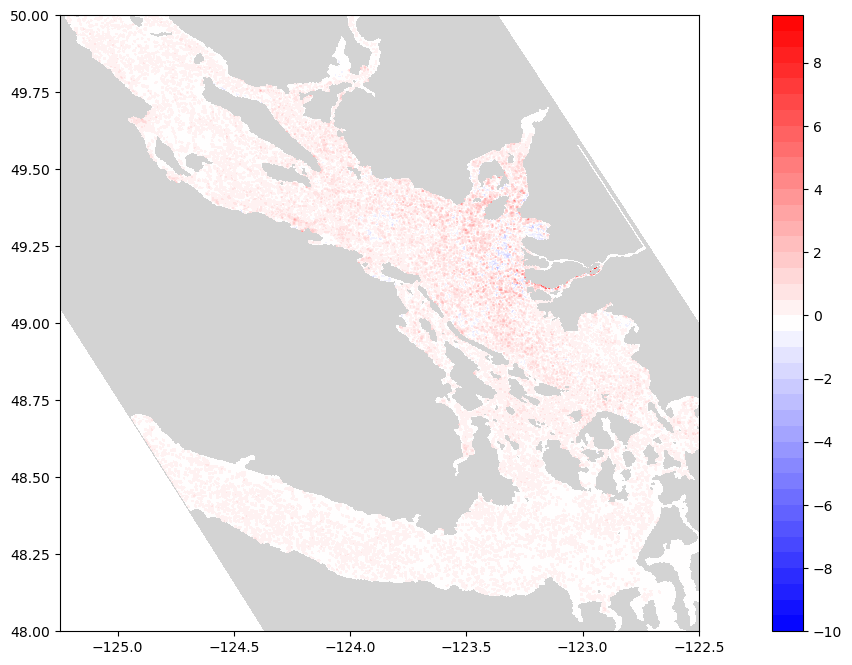

In [11]:
z = mask.gdepw_0[0,:,240,340]
cend=conc*0.01*(2118/5)*(2*3600/2.6e6)/2
cend1=(conc1*0.01*(2118/5)*(2*3600/2.6e6)/2)-cend
cend2=conc2*0.01*(2118/5)*(2*3600/2.6e6)/2
# cend3=conc3*0.1*(2118/5)*(2*3600/2.6e6)

fig = plt.figure(figsize=(19, 8))
#axs = plt.axes(xlim=(-123.25,-122.8),ylim=(49,49.25))
axs=plt.axes(xlim=(-125.25,-122.5),ylim=(48,50))

levels = np.linspace(1,800,50)

colors = list(cmocean.cm.dense(np.linspace(0,1,len(levels)-1)))
colors[-1] = "red"
cmap = matplotlib.colors.ListedColormap(colors,"", len(colors))


# #axs.contourf(coords.nav_lon, coords.nav_lat, mask.bathym[0,:,:],levels=np.arange(0,400,10),cmap=cmocean.cm.deep,alpha=1)
a=axs.contourf(coords.nav_lon, coords.nav_lat, cend1[:,:,0],levels=np.arange(-10,10,0.5),cmap='bwr')
 #axs.scatter(frs_lon,frs_lat)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')

# #axs.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
plt.colorbar(a)

axs.set_aspect(1/np.sin(np.deg2rad(49)))

In [12]:
# Make map
fig, ax = plt.subplots(figsize=(38, 16), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-125.25, -122.5, 48, 50], crs=crs.PlateCarree())

ax.add_feature(feature.GSHHSFeature('high', facecolor='#EEEDEC',edgecolor='#EEEDEC'),zorder=2)
im=ax.contourf(coords.nav_lon, coords.nav_lat, cend[:,:,0],transform=crs.PlateCarree(),levels=np.arange(1,25,1),cmap=cmap,extend='max')

gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=[-125,-124,-123,-122], ylocs=[48.5,49,49.5],zorder=5)
gl.top_labels, gl.right_labels = False, False

cbar = fig.colorbar(im, location='bottom',aspect=60,shrink=0.3,pad=0.05)

cbar.set_label('MP concentration')

ax.add_patch(mpatches.Rectangle(xy=[-124,49.3], width=0.2, height=0.1,
                                    facecolor=(245/255, 255/255, 40/255),
                                    alpha=0.5,
                                    transform=crs.PlateCarree(),zorder=5)
                 )
ax.add_patch(mpatches.Rectangle(xy=[-123.3,49.1], width=0.1, height=0.26,
                                    facecolor='green',
                                    alpha=0.5,
                                    transform=crs.PlateCarree(),zorder=5)
                 )
ax.add_patch(mpatches.Rectangle(xy=[-123.2,49.1], width=0.04, height=0.03,
                                    facecolor='black',
                                    alpha=0.5,
                                    transform=crs.PlateCarree(),zorder=5)
                 )

# ax.add_patch(mpatches.Rectangle(xy=[-123.5,48.25], width=0.2, height=0.1,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
#                  )

# ax.add_patch(mpatches.Rectangle(xy=[-123.35,48.5], width=0.2, height=0.1,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
                #  )

ax.text(-0.05, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
ax.text(0.5, -0.05, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")

Text(0.5, -0.05, 'Longitude')

Error in callback <function flush_figures at 0x7f25141b0d60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [23]:
vol=mask.volume
def get_conc(latmin,latmax,lonmin,lonmax, conc):
    jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
    j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    j.append(jjii.jj.sel(lats=latmin, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmin, lons=lonmax, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmin, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmin, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmax, method='nearest').item())
    a=[min(j),max(j),min(i),max(i)]
    Len = (a[1]-a[0])*(a[3]-a[2])
    SD = []
    Mean = []
    for ki in range(len(z)):
        values = []
        vols = []
        for j in range(a[0],a[1],1):
            for i in range(a[2],a[3],1):
                values.append(conc[j,i,ki])
                vols.append(vol[ki,j,i])
        values = np.array(values)
        vols = np.array(vols)
        Mean.append(np.sum(values)/np.sum(vols))
        valuess = np.divide(values,vols)
        SD.append(np.std(valuess)/np.sqrt(Len))
    return Mean,SD

In [20]:
# jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
# # [jjii.ii.sel(lats=48.520555, lons=-123.238390, method='nearest').item()] 
# # #[jjii.jj.sel(lats=48.520555, lons=-123.238390, method='nearest').item()]

In [ ]:
def MP_measur(ax,RES):
    Fraser_MP = RES.iloc[:,[1,7,13,19,25]]
    Fraser_SE = RES.iloc[:,[2,8,14,20,26]]
    Lori_MP = RES.iloc[:,[3,9,15,21,27]]
    Lori_SE = RES.iloc[:,[4,10,16,22,28]]
    SoG_MP = RES.iloc[:,[5,11,17,23,29]]
    SoG_SE = RES.iloc[:,[6,12,18,24,30]]
    label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']
    for i in range(5):
        ax[1].errorbar(Lori_MP.iloc[:,i], -z, xerr = Lori_SE.iloc[:,i],label=label[i])
        ax[0].errorbar(Fraser_MP.iloc[:,i], -z, xerr = Fraser_SE.iloc[:,i],label=label[i])
        ax[2].errorbar(SoG_MP.iloc[:,i], -z, xerr = SoG_SE.iloc[:,i],label=label[i])
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_ylim(-20,0.5)
    ax[1].set_ylim(-20,0.5)
    ax[2].set_ylim(-20,0.5)
    return 

In [ ]:
# RES = pd.read_csv('results.csv')
# fig,axs=plt.subplots(1,3,figsize=(15,10))
# MP_measur(axs,RES)
# axs[0].set_title('MP concentration in the Fraser')
# axs[1].set_title("MP concentration Lori's sampling area")
# axs[2].set_title('MP concentration in the SoG')


In [ ]:
def MP_measure2(ax,conc,label): 
    Fraser_MP,Fraser_SE=get_conc(48.5,48.6,-123.35,-123.15,conc)

    ax.errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax.legend()
    ax.set_ylim(-100,0.5)

fig,axs=plt.subplots(1,1,figsize=(5,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

MP_measure2(axs,conc,label[0])
MP_measure2(axs,conc1,label[1])
MP_measure2(axs,conc2,label[2])
MP_measure2(axs,conc3,label[3])
MP_measure2(axs,conc4,label[4])

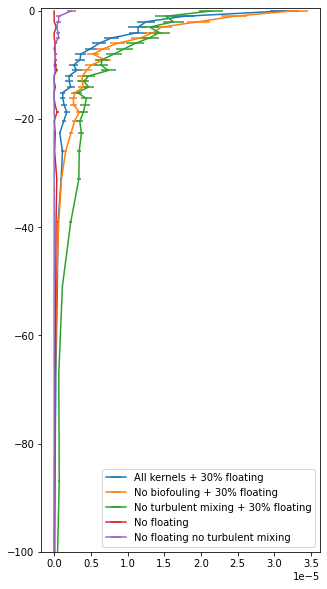

In [ ]:
def MP_measure2(ax,conc,label):
    Fraser_MP,Fraser_SE=get_conc(48.25,48.35,-123.5,-123.3,conc)

    ax.errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax.legend()
    ax.set_ylim(-100,0.5)
    


fig,axs=plt.subplots(1,1,figsize=(5,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

MP_measure2(axs,conc,label[0])
MP_measure2(axs,conc1,label[1])
MP_measure2(axs,conc2,label[2])
MP_measure2(axs,conc3,label[3])
MP_measure2(axs,conc4,label[4])

In [ ]:
def MP_measure(ax,conc,label):
    Fraser_MP,Fraser_SE=get_conc(49.1,49.13,-123.2,-123.16,conc)
    SoG_MP,SoG_SE =get_conc(49.3,49.4,-124,-123.8,conc)
    Lori_MP,Lori_SE =get_conc(49.1,49.36,-123.3,-123.2,conc)
    ax[1].errorbar(Lori_MP, -z, xerr = Lori_SE,label=label)
    ax[0].errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax[2].errorbar(SoG_MP, -z, xerr = SoG_SE,label=label)
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_ylim(-20,0.5)
    ax[1].set_ylim(-20,0.5)
    ax[2].set_ylim(-20,0.5)
    return Fraser_MP,Fraser_SE, Lori_MP,Lori_SE,SoG_MP,SoG_SE

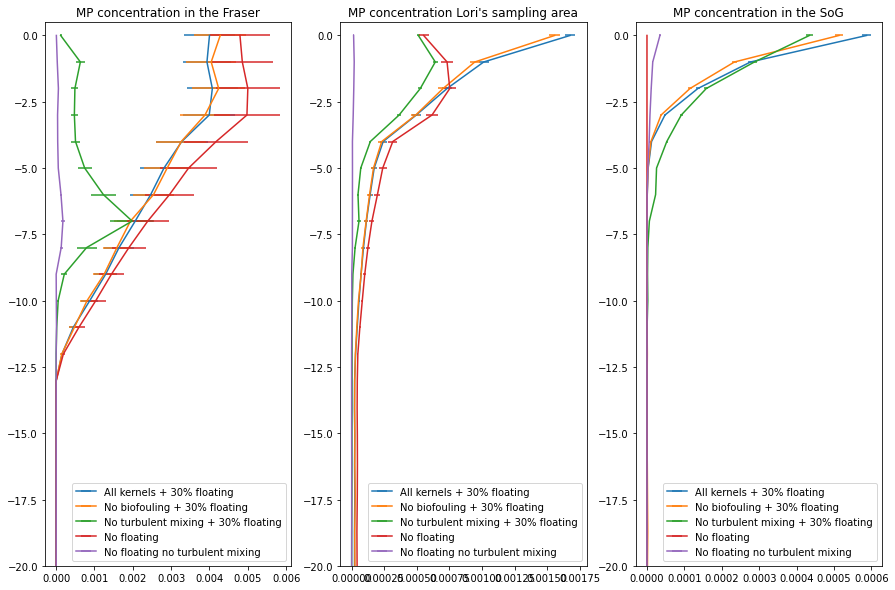

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(15,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

F1,FE1,L1,LE1,S1,SE1=MP_measure(axs,conc,label[0])
F2,FE2,L2,LE2,S2,SE2=MP_measure(axs,conc1,label[1])
F3,FE3,L3,LE3,S3,SE3=MP_measure(axs,conc2,label[2])
F4,FE4,L4,LE4,S4,SE4=MP_measure(axs,conc3,label[3])
F5,FE5,L5,LE5,S5,SE5=MP_measure(axs,conc4,label[4])
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[2].set_title('MP concentration in the SoG')
dict = {'F1':F1,'FE1':FE1,'L1':L1,'LE1':LE1,'S1':S1,'SE1':SE1,'F2':F2,'FE2':FE2,'L2':L2,'LE2':LE2,'S2':S2,'SE2':SE2,'F3':F3,'FE3':FE3,'L3':L3,'LE3':LE3,'S3':S3,'SE3':SE3,'F4':F4,'FE4':FE4,'L4':L4,'LE4':LE4,'S4':S4,'SE4':SE4,'F5':F5,'FE5':FE5,'L5':L5,'LE5':LE5,'S5':S5,'SE5':SE5}
df = pd.DataFrame(dict) 
df.to_csv('resultsnSummer5.csv')

Text(0.5, 1.0, 'MP concentration in the SoG')

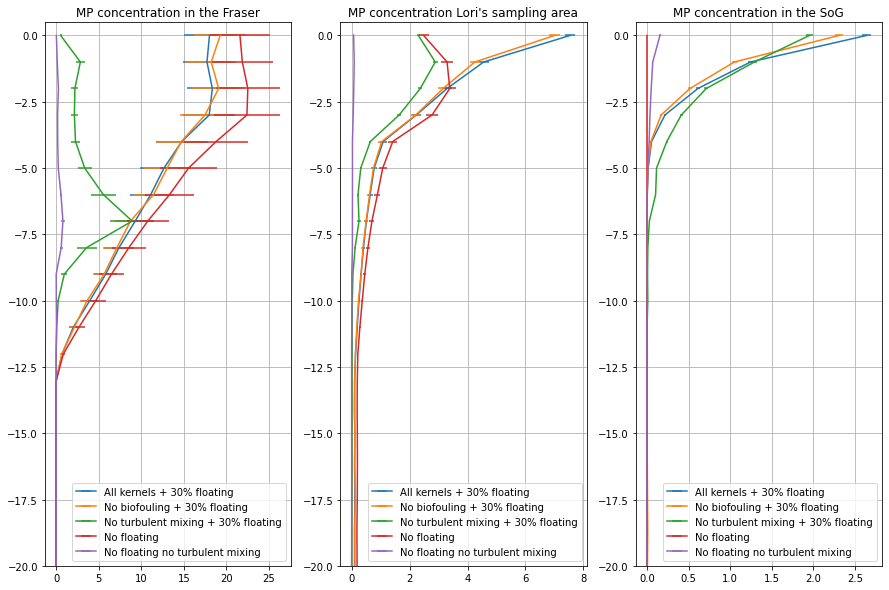

In [ ]:
RES = pd.read_csv('resultsnSummer5.csv')*4500
fig,axs=plt.subplots(1,3,figsize=(15,10))
MP_measur(axs,RES)
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[2].set_title('MP concentration in the SoG')

In [ ]:
# RES = pd.read_csv('resultsn.csv')*4500
# fig,axs=plt.subplots(1,3,figsize=(15,10))
# MP_measur(axs,RES)
# axs[0].set_title('MP concentration in the Fraser')
# axs[1].set_title("MP concentration Lori's sampling area")
# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[2].set_title('MP concentration in the SoG')

In [ ]:
# dW = np.random.normalvariate(0, sqrt(particle.dt)) 
# wprime = Kzdz + (sqrt(2*Kz)*dW)/particle.dt 
# dzp = wprime*particle.dt

In [ ]:
# fig = plt.figure(figsize=(19, 8))
# anim = mapanimationd(conc,clon,clat,fps=1)
# f = r"/home/jvalenti/MOAD/animations/Fraser2.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [ ]:
#  with open(f,'rb') as anim:
#     display(Image(anim.read()))